# Association Rules Mining: Incident Pattern Discovery

**Purpose:** Discover if-then relationships and co-occurrence patterns in public safety incidents using Association Rules Mining (Apriori algorithm).

**Key Objectives:**
- Mine frequent incident patterns (itemsets) that occur together across temporal, categorical, and geographic dimensions
- Generate association rules revealing predictive relationships (e.g., "IF weekday morning in downtown → THEN traffic incident")
- Compare rule patterns between San Francisco and San Jose to identify city-specific behaviors
- Validate rule quality using support, confidence, lift, and statistical significance tests
- Extract actionable insights for predictive policing and resource optimization

**Methodology:**
- **Algorithm:** Apriori algorithm for frequent itemset mining
- **Transaction Model:** Each incident = transaction with items (hour bin, day type, incident category, location)
- **Rule Generation:** Association rules with minimum confidence and lift thresholds
- **Validation:** Chi-squared tests for statistical significance, cross-city comparison

**Expected Deliverables:**
- 50-100 high-confidence association rules (confidence > 30%, lift > 1.5)
- Cross-city rule comparison identifying SF-specific and SJ-specific patterns
- Temporal pattern rules (hour-of-day, day-of-week, seasonal)
- Geographic pattern rules (district-level, neighborhood-level)
- 4-5 professional visualizations (rule networks, heatmaps, bar charts)
- Actionable deployment recommendations based on discovered rules

---

## **Association Rules Primer**

**What are Association Rules?**
- **Format:** {Antecedent} → {Consequent} (IF-THEN relationship)
- **Example:** {Weekday, Morning, Downtown} → {Theft} [Confidence: 65%, Lift: 2.3]
- **Interpretation:** When incidents occur on weekdays in downtown mornings, there's a 65% chance it's theft, which is 2.3x higher than baseline theft probability.

**Key Metrics:**
1. **Support:** P(A ∩ B) - How frequently does the pattern occur?
2. **Confidence:** P(B|A) - How reliable is the rule?
3. **Lift:** P(B|A) / P(B) - How much better than random chance?
4. **Conviction:** (1 - P(B)) / (1 - Confidence) - Rule strength metric

**Why This Matters:**
Association rules reveal hidden patterns invisible in aggregate statistics. By discovering predictable incident combinations, public safety agencies can:
- Deploy resources proactively (before incidents occur)
- Identify high-risk time-location-type combinations
- Optimize patrol schedules based on rule patterns
- Reduce response times by anticipating incident types

---

In [1]:
## 1. Import Libraries and Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Association Rules Mining
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Data manipulation
from collections import Counter
from itertools import combinations

# Statistical validation
from scipy.stats import chi2_contingency

# Date/time handling
from datetime import datetime

# Plot settings
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11
sns.set_style("whitegrid")
sns.set_palette("husl")

## 2. Load and Prepare Transaction Data

**Objective:** Transform incident data into transaction format suitable for Apriori algorithm.

**Transaction Model:**
- Each incident = 1 transaction
- Transaction items = attributes describing the incident (hour bin, day type, incident category, location)
- Example transaction: `['Hour_Morning', 'Weekday', 'Theft', 'Downtown', 'SF']`

**Item Categories:**
1. **Temporal Items:**
   - Hour bins: `Hour_Night` (0-5), `Hour_Morning` (6-11), `Hour_Afternoon` (12-17), `Hour_Evening` (18-23)
   - Day type: `Weekday`, `Weekend`
   - Day names: `Monday`, `Tuesday`, ..., `Sunday`
   - Quarters: `Q1`, `Q2`, `Q3`, `Q4`

2. **Incident Type Items:**
   - High-level categories: `Theft/Property`, `Violent`, `Disturbance/Suspicious`, `Traffic`, etc.

3. **Location Items:**
   - Police districts: `District_<name>`
   - Neighborhoods: `Neighborhood_<name>` (top 10-15 per city)

4. **City Identifier:**
   - `SF` or `SJ`

**Expected Outcome:** Binary matrix where rows = incidents, columns = items, values = True/False (item present/absent).

---

In [2]:
# Load San Francisco data
print("\n Loading San Francisco data...")
df_sf = pd.read_csv(
    '../data/processed/sf_incidents_cleaned.csv',
    index_col='Incident DateTime',
    parse_dates=True
)
print(f"   SF loaded: {len(df_sf):,} incidents")
print(f"   Date range: {df_sf.index.min().date()} to {df_sf.index.max().date()}")

# Load San Jose data
print("\n Loading San Jose data...")
df_sj = pd.read_csv(
    '../data/processed/sj_calls_cleaned.csv',
    index_col='Incident DateTime',
    parse_dates=True
)
print(f"   SJ loaded: {len(df_sj):,} incidents")
print(f"   Date range: {df_sj.index.min().date()} to {df_sj.index.max().date()}")

# Add city identifier column
df_sf['City'] = 'San Francisco'
df_sj['City'] = 'San Jose'

# Combine datasets
print("\n Combining datasets...")
df_combined = pd.concat([df_sf, df_sj], axis=0)
print(f"   Combined dataset: {len(df_combined):,} total incidents")

print(f"\n Total incidents: {len(df_combined):,}")
print(f"   • San Francisco: {len(df_sf):,} ({100*len(df_sf)/len(df_combined):.1f}%)")
print(f"   • San Jose: {len(df_sj):,} ({100*len(df_sj)/len(df_combined):.1f}%)")
print(f"\n Combined date range: {df_combined.index.min().date()} to {df_combined.index.max().date()}")
print(f"\n Available columns: {len(df_combined.columns)}")
print(f"   {df_combined.columns.tolist()}")

# Display sample
print("\n Sample incidents (first 3 rows):")
print(df_combined[['City', 'Hour', 'Day_of_Week_Name', 'Is_Weekend', 
                    'Incident_High_Level_Category', 'Police_District', 'Neighborhood']].head(3))


 Loading San Francisco data...
   SF loaded: 823,541 incidents
   Date range: 2018-01-01 to 2025-11-16

 Loading San Jose data...
   SJ loaded: 1,170,667 incidents
   Date range: 2018-01-01 to 2025-11-15

 Combining datasets...
   Combined dataset: 1,994,208 total incidents

 Total incidents: 1,994,208
   • San Francisco: 823,541 (41.3%)
   • San Jose: 1,170,667 (58.7%)

 Combined date range: 2018-01-01 to 2025-11-16

 Available columns: 16
   ['Incident_High_Level_Category', 'Resolution', 'Neighborhood', 'Police_District', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month', 'Year', 'Day_of_Week', 'Day_of_Week_Name', 'Month_Name', 'Quarter', 'Is_Weekend', 'City']

 Sample incidents (first 3 rows):
                              City  Hour Day_of_Week_Name  Is_Weekend  \
Incident DateTime                                                       
2025-08-27 00:37:00  San Francisco     0        Wednesday           0   
2025-07-17 15:00:00  San Francisco    15         Thursday           0   
202

In [3]:
print("\n[1/4] Creating temporal items...")

# Initialize list to store all transactions
transactions = []

# Function to create hour bin item
def get_hour_bin(hour):
    """Map hour (0-23) to 4 time-of-day bins."""
    if 0 <= hour <= 5:
        return 'Hour_Night'
    elif 6 <= hour <= 11:
        return 'Hour_Morning'
    elif 12 <= hour <= 17:
        return 'Hour_Afternoon'
    else:  # 18-23
        return 'Hour_Evening'

# Add hour bin column
df_combined['Hour_Bin'] = df_combined['Hour'].apply(get_hour_bin)

# Add weekday/weekend item
df_combined['Day_Type'] = df_combined['Is_Weekend'].apply(
    lambda x: 'Weekend' if x == 1 else 'Weekday'
)

# Add quarter item
df_combined['Quarter_Item'] = df_combined['Quarter'].apply(lambda x: f'Q{x}')

print(f"   Hour bins created: {df_combined['Hour_Bin'].nunique()} unique bins")
print(f"      Distribution:")
for bin_name, count in df_combined['Hour_Bin'].value_counts().sort_index().items():
    print(f"         • {bin_name}: {count:,} incidents ({100*count/len(df_combined):.1f}%)")

print(f"\n   Day type created:")
print(f"      • Weekday: {(df_combined['Day_Type']=='Weekday').sum():,} incidents ({100*(df_combined['Day_Type']=='Weekday').sum()/len(df_combined):.1f}%)")
print(f"      • Weekend: {(df_combined['Day_Type']=='Weekend').sum():,} incidents ({100*(df_combined['Day_Type']=='Weekend').sum()/len(df_combined):.1f}%)")

print(f"\n   Quarter items created: Q1, Q2, Q3, Q4")
print(f"   Day names available: {df_combined['Day_of_Week_Name'].nunique()} days")


[1/4] Creating temporal items...
   Hour bins created: 4 unique bins
      Distribution:
         • Hour_Afternoon: 652,081 incidents (32.7%)
         • Hour_Evening: 598,194 incidents (30.0%)
         • Hour_Morning: 443,222 incidents (22.2%)
         • Hour_Night: 300,711 incidents (15.1%)

   Day type created:
      • Weekday: 1,429,463 incidents (71.7%)
      • Weekend: 564,745 incidents (28.3%)

   Quarter items created: Q1, Q2, Q3, Q4
   Day names available: 7 days


In [4]:
print("\n[2/4] Creating incident type items...")

# Get incident type distribution
incident_types = df_combined['Incident_High_Level_Category'].value_counts()
print(f"   Incident types found: {len(incident_types)}")
print(f"\n   Top 5 incident types:")
for idx, (category, count) in enumerate(incident_types.head(5).items(), 1):
    pct = 100 * count / len(df_combined)
    print(f"      {idx}. {category}: {count:,} ({pct:.1f}%)")

# Prefix incident types with 'Type_' for clarity
df_combined['Incident_Type_Item'] = 'Type_' + df_combined['Incident_High_Level_Category']

print(f"\n   Incident type items created with 'Type_' prefix")
print(f"      Example: 'Type_Theft/Property', 'Type_Violent', etc.")


[2/4] Creating incident type items...
   Incident types found: 8

   Top 5 incident types:
      1. Theft/Property: 532,077 (26.7%)
      2. Disturbance/Suspicious: 526,528 (26.4%)
      3. Traffic/Vehicle: 274,635 (13.8%)
      4. Other: 217,014 (10.9%)
      5. Non-Criminal/Admin: 203,750 (10.2%)

   Incident type items created with 'Type_' prefix
      Example: 'Type_Theft/Property', 'Type_Violent', etc.


In [5]:
print("\n[3/4] Creating location items...")

# Police districts
district_counts = df_combined['Police_District'].value_counts()
print(f"   Police districts found: {len(district_counts)}")
print(f"\n   Top 5 districts:")
for idx, (district, count) in enumerate(district_counts.head(5).items(), 1):
    pct = 100 * count / len(df_combined)
    print(f"      {idx}. {district}: {count:,} ({pct:.1f}%)")

# Prefix districts with 'District_'
df_combined['District_Item'] = 'District_' + df_combined['Police_District'].astype(str)

# Neighborhoods (top 15 per city to reduce sparsity)
print(f"\n   Processing neighborhoods...")

# Get top 15 neighborhoods per city
top_neighborhoods_sf = df_sf['Neighborhood'].value_counts().head(15).index.tolist()
top_neighborhoods_sj = df_sj['Neighborhood'].value_counts().head(15).index.tolist()

print(f"      • SF top neighborhoods: {len(top_neighborhoods_sf)}")
print(f"      • SJ top neighborhoods: {len(top_neighborhoods_sj)}")

# Create neighborhood item (only for top neighborhoods, others = 'Other')
def get_neighborhood_item(row):
    """Create neighborhood item with city prefix."""
    city = row['City']
    neighborhood = row['Neighborhood']
    
    if city == 'San Francisco' and neighborhood in top_neighborhoods_sf:
        return f'Neighborhood_{neighborhood}_SF'
    elif city == 'San Jose' and neighborhood in top_neighborhoods_sj:
        return f'Neighborhood_{neighborhood}_SJ'
    else:
        return f'Neighborhood_Other_{city[:2]}'

df_combined['Neighborhood_Item'] = df_combined.apply(get_neighborhood_item, axis=1)

# Count unique neighborhood items
unique_neighborhoods = df_combined['Neighborhood_Item'].nunique()
print(f"\n   Neighborhood items created: {unique_neighborhoods} unique items")
print(f"      (Top 15 per city + 'Other' category)")


[3/4] Creating location items...
   Police districts found: 12

   Top 5 districts:
      1. San Jose: 1,170,667 (58.7%)
      2. Central: 119,093 (6.0%)
      3. Northern: 115,167 (5.8%)
      4. Mission: 105,833 (5.3%)
      5. Southern: 100,225 (5.0%)

   Processing neighborhoods...
      • SF top neighborhoods: 15
      • SJ top neighborhoods: 15

   Neighborhood items created: 31 unique items
      (Top 15 per city + 'Other' category)


In [6]:
print("\n[4/4] Creating city identifier items...")

# Simple city prefix
df_combined['City_Item'] = df_combined['City'].apply(lambda x: 'SF' if x == 'San Francisco' else 'SJ')

print(f"   ✓ City items created:")
print(f"      • SF: {(df_combined['City_Item']=='SF').sum():,} incidents")
print(f"      • SJ: {(df_combined['City_Item']=='SJ').sum():,} incidents")

print(f"\n Item categories ready:")
print(f"   • Temporal: Hour bins (4), Day type (2), Day names (7), Quarters (4)")
print(f"   • Incident types: {df_combined['Incident_Type_Item'].nunique()} unique")
print(f"   • Districts: {df_combined['District_Item'].nunique()} unique")
print(f"   • Neighborhoods: {df_combined['Neighborhood_Item'].nunique()} unique")
print(f"   • City: 2 (SF, SJ)")
print(f"\n Estimated total unique items: ~{4 + 2 + 7 + 4 + df_combined['Incident_Type_Item'].nunique() + df_combined['District_Item'].nunique() + df_combined['Neighborhood_Item'].nunique() + 2}")


[4/4] Creating city identifier items...
   ✓ City items created:
      • SF: 823,541 incidents
      • SJ: 1,170,667 incidents

 Item categories ready:
   • Temporal: Hour bins (4), Day type (2), Day names (7), Quarters (4)
   • Incident types: 8 unique
   • Districts: 12 unique
   • Neighborhoods: 31 unique
   • City: 2 (SF, SJ)

 Estimated total unique items: ~70


In [7]:
print("\n Assembling transactions (each incident = 1 transaction)...")

# Build transaction list (list of lists)
transactions = []

for idx, row in df_combined.iterrows():
    transaction = [
        # Temporal items
        row['Hour_Bin'],
        row['Day_Type'],
        row['Day_of_Week_Name'],
        row['Quarter_Item'],
        
        # Incident type
        row['Incident_Type_Item'],
        
        # Location
        row['District_Item'],
        row['Neighborhood_Item'],
        
        # City
        row['City_Item']
    ]
    
    transactions.append(transaction)

print(f"   Transactions created: {len(transactions):,}")
print(f"   Items per transaction: {len(transactions[0])}")

# Display sample transactions
print(f"\n Sample transactions (first 3):")
for i in range(min(3, len(transactions))):
    print(f"\n   Transaction {i+1}:")
    print(f"      {transactions[i]}")


 Assembling transactions (each incident = 1 transaction)...
   Transactions created: 1,994,208
   Items per transaction: 8

 Sample transactions (first 3):

   Transaction 1:
      ['Hour_Night', 'Weekday', 'Wednesday', 'Q3', 'Type_Violent', 'District_Park', 'Neighborhood_Other_Sa', 'SF']

   Transaction 2:
      ['Hour_Afternoon', 'Weekday', 'Thursday', 'Q3', 'Type_Fraud', 'District_Park', 'Neighborhood_Other_Sa', 'SF']

   Transaction 3:
      ['Hour_Evening', 'Weekend', 'Saturday', 'Q3', 'Type_Theft/Property', 'District_Northern', 'Neighborhood_Hayes Valley_SF', 'SF']


In [8]:
print("\n Using TransactionEncoder to create one-hot encoded DataFrame...")

# Initialize TransactionEncoder
te = TransactionEncoder()

# Fit and transform transactions
te_ary = te.fit(transactions).transform(transactions)

# Create DataFrame
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"   Binary matrix created")
print(f"      • Rows (transactions): {df_encoded.shape[0]:,}")
print(f"      • Columns (unique items): {df_encoded.shape[1]:,}")
print(f"      • Matrix size: {df_encoded.shape[0] * df_encoded.shape[1]:,} cells")
print(f"      • Sparsity: {100 * (1 - df_encoded.sum().sum() / (df_encoded.shape[0] * df_encoded.shape[1])):.2f}%")

# Display sample
print(f"\n Sample binary matrix (first 3 transactions, first 10 items):")
print(df_encoded.iloc[:3, :10])

print(f"\n Dataset prepared:")
print(f"   • Total transactions: {len(df_encoded):,}")
print(f"   • Unique items: {len(df_encoded.columns):,}")


 Using TransactionEncoder to create one-hot encoded DataFrame...
   Binary matrix created
      • Rows (transactions): 1,994,208
      • Columns (unique items): 70
      • Matrix size: 139,594,560 cells
      • Sparsity: 88.57%

 Sample binary matrix (first 3 transactions, first 10 items):
   District_Bayview  District_Central  District_Ingleside  District_Mission  \
0             False             False               False             False   
1             False             False               False             False   
2             False             False               False             False   

   District_Northern  District_Out of SF  District_Park  District_Richmond  \
0              False               False           True              False   
1              False               False           True              False   
2               True               False          False              False   

   District_San Jose  District_Southern  
0              False              Fa

In [9]:
print("\nAnalyzing item frequencies (support values)...")

# Calculate item support (% of transactions containing each item)
item_support = df_encoded.mean().sort_values(ascending=False)

print(f"\nTop 20 Most Frequent Items:")
print(f"\n{'Item':<40} {'Support':<12} {'Count':<15}")
print("-" * 67)

for idx, (item, support) in enumerate(item_support.head(20).items(), 1):
    count = int(support * len(df_encoded))
    print(f"{idx:2}. {item:<37} {support:>8.4f} ({100*support:>5.1f}%)  {count:>10,}")


Analyzing item frequencies (support values)...

Top 20 Most Frequent Items:

Item                                     Support      Count          
-------------------------------------------------------------------
 1. Weekday                                 0.7168 ( 71.7%)   1,429,463
 2. Neighborhood_Other_Sa                   0.6778 ( 67.8%)   1,351,707
 3. District_San Jose                       0.5870 ( 58.7%)   1,170,667
 4. SJ                                      0.5870 ( 58.7%)   1,170,667
 5. SF                                      0.4130 ( 41.3%)     823,541
 6. Hour_Afternoon                          0.3270 ( 32.7%)     652,081
 7. Hour_Evening                            0.3000 ( 30.0%)     598,194
 8. Weekend                                 0.2832 ( 28.3%)     564,745
 9. Type_Theft/Property                     0.2668 ( 26.7%)     532,077
10. Q3                                      0.2657 ( 26.6%)     529,956
11. Type_Disturbance/Suspicious             0.2640 ( 26.4%)     

In [10]:
# Item category breakdown
print(f"\n Item Category Breakdown:")

item_categories = {
    'Temporal': ['Hour_', 'Weekday', 'Weekend', 'Monday', 'Tuesday', 'Wednesday', 
                 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Q1', 'Q2', 'Q3', 'Q4'],
    'Incident Type': ['Type_'],
    'District': ['District_'],
    'Neighborhood': ['Neighborhood_'],
    'City': ['SF', 'SJ']
}

for category, prefixes in item_categories.items():
    category_items = [col for col in df_encoded.columns 
                      if any(col.startswith(p) or col == p for p in prefixes)]
    print(f"\n   {category}: {len(category_items)} items")
    
    if len(category_items) <= 10:
        for item in category_items:
            support = item_support[item]
            print(f"      • {item}: {support:.4f} ({100*support:.1f}%)")


 Item Category Breakdown:

   Temporal: 17 items

   Incident Type: 8 items
      • Type_Alarm: 0.0314 (3.1%)
      • Type_Disturbance/Suspicious: 0.2640 (26.4%)
      • Type_Fraud: 0.0144 (1.4%)
      • Type_Non-Criminal/Admin: 0.1022 (10.2%)
      • Type_Other: 0.1088 (10.9%)
      • Type_Theft/Property: 0.2668 (26.7%)
      • Type_Traffic/Vehicle: 0.1377 (13.8%)
      • Type_Violent: 0.0747 (7.5%)

   District: 12 items

   Neighborhood: 31 items

   City: 2 items
      • SF: 0.4130 (41.3%)
      • SJ: 0.5870 (58.7%)


**Transaction Structure:**
- Each incident = 1 transaction with 8 items
- Items: Hour bin (4 options) + Day type (2) + Day name (7) + Quarter (4) + Incident type + District + Neighborhood + City

**Item Categories:**
1. **Temporal:** `Hour_Night/Morning/Afternoon/Evening`, `Weekday/Weekend`, day names, `Q1-Q4`
2. **Incident Type:** `Type_<category>` (e.g., `Type_Theft/Property`)
3. **Location:** `District_<name>`, `Neighborhood_<name>_<city>` (top 15 per city)
4. **City:** `SF` or `SJ`

**Output:** Binary matrix (rows = transactions, columns = items, values = True/False)

---

## 3. Frequent Itemset Discovery

**Objective:** Discover frequent combinations of incident attributes using Apriori algorithm.

**What are Frequent Itemsets?**
- Combinations of items that appear together frequently in transactions
- Example: {Weekday, Morning, Theft} appearing in 15,000+ incidents
- Foundation for generating association rules in next section

**Apriori Algorithm:**
- Iteratively finds frequent itemsets of increasing size (1-item, 2-item, 3-item, etc.)
- Uses minimum support threshold to filter rare patterns
- Principle: If an itemset is infrequent, all its supersets are also infrequent

**Parameters:**
- **min_support = 0.01 (1%):** Itemset must appear in at least ~20,000 incidents
- **Reasoning:** Balance between discovering meaningful patterns and computational efficiency
  - Too low (0.001): Captures rare/noisy patterns, slow computation
  - Too high (0.05): Misses important mid-frequency patterns
  - 1% threshold: Ensures patterns are statistically significant across 2M+ incidents

**Expected Outcomes:**
- 50-150 frequent itemsets (1-item through 4-item combinations)
- Itemset size distribution (most patterns will be 2-3 items)
- Top patterns by support value

---

In [ ]:
min_support = 0.015
print("\n[Step 1] Running Apriori algorithm...")
print(f"   Parameters:")
print(f"      - min_support: {min_support} ({min_support * 100}%)")
print(f"      - Minimum incident count: {int(min_support * len(df_encoded)):,}")
print(f"      - Use_colnames: True (return item names, not indices)")
print(f"      - Verbose: 1 (progress updates)")

frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True, verbose=1)
print(f"\n   Algorithm complete")
print(f"      - Frequent itemsets found: {len(frequent_itemsets):,}")

# Add itemset length column
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"\n[Step 2] Itemset statistics:")
print(f"   Total itemsets: {len(frequent_itemsets):,}")
print(f"   Support range: {frequent_itemsets['support'].min():.4f} to {frequent_itemsets['support'].max():.4f}")
print(f"   Itemset sizes: {frequent_itemsets['length'].min()} to {frequent_itemsets['length'].max()} items")


[Step 1] Running Apriori algorithm...
   Parameters:
      - min_support: 0.015 (1.5%)
      - Minimum incident count: 29,913
      - Use_colnames: True (return item names, not indices)
      - Verbose: 1 (progress updates)
Processing 861 combinations | Sampling itemset size 765

   Algorithm complete
      - Frequent itemsets found: 2,771
      - Computation time: < 1 minute (for 2M transactions)

[Step 2] Itemset statistics:
   Total itemsets: 2,771
   Support range: 0.0150 to 0.7168
   Itemset sizes: 1 to 6 items


In [12]:
# Display sample
print(f"\n[Step 3] Sample frequent itemsets (first 10):")
print(frequent_itemsets[['support', 'itemsets', 'length']].head(10).to_string(index=False))



[Step 3] Sample frequent itemsets (first 10):
 support             itemsets  length
0.038578   (District_Bayview)       1
0.059719   (District_Central)       1
0.033531 (District_Ingleside)       1
0.053070   (District_Mission)       1
0.057751  (District_Northern)       1
0.018788      (District_Park)       1
0.024607  (District_Richmond)       1
0.587034  (District_San Jose)       1
0.050258  (District_Southern)       1
0.030788   (District_Taraval)       1


In [13]:
size_distribution = frequent_itemsets['length'].value_counts().sort_index()

print(f"\nItemsets by size:")
print(f"\n{'Size':<15} {'Count':<12} {'Percentage':<15}")
print("-" * 42)

for size, count in size_distribution.items():
    pct = 100 * count / len(frequent_itemsets)
    print(f"{size}-item{' '*(9-len(str(size)))} {count:<12,} {pct:>5.1f}%")

print(f"\n{'Total':<15} {len(frequent_itemsets):<12,} 100.0%")

# Interpretation
print(f"\nKey Observations:")
max_size = size_distribution.idxmax()
max_count = size_distribution.max()
print(f"   - Most common itemset size: {max_size}-item ({max_count:,} itemsets)")
print(f"   - Single items (1-item): {size_distribution.get(1, 0):,} (all items above 1% support)")
print(f"   - Complex patterns (3+ items): {size_distribution[size_distribution.index >= 3].sum():,} itemsets")


Itemsets by size:

Size            Count        Percentage     
------------------------------------------
1-item         43             1.6%
2-item         339           12.2%
3-item         859           31.0%
4-item         922           33.3%
5-item         492           17.8%
6-item         116            4.2%

Total           2,771        100.0%

Key Observations:
   - Most common itemset size: 4-item (922 itemsets)
   - Single items (1-item): 43 (all items above 1% support)
   - Complex patterns (3+ items): 2,389 itemsets



[Visualization] Itemset size distribution...


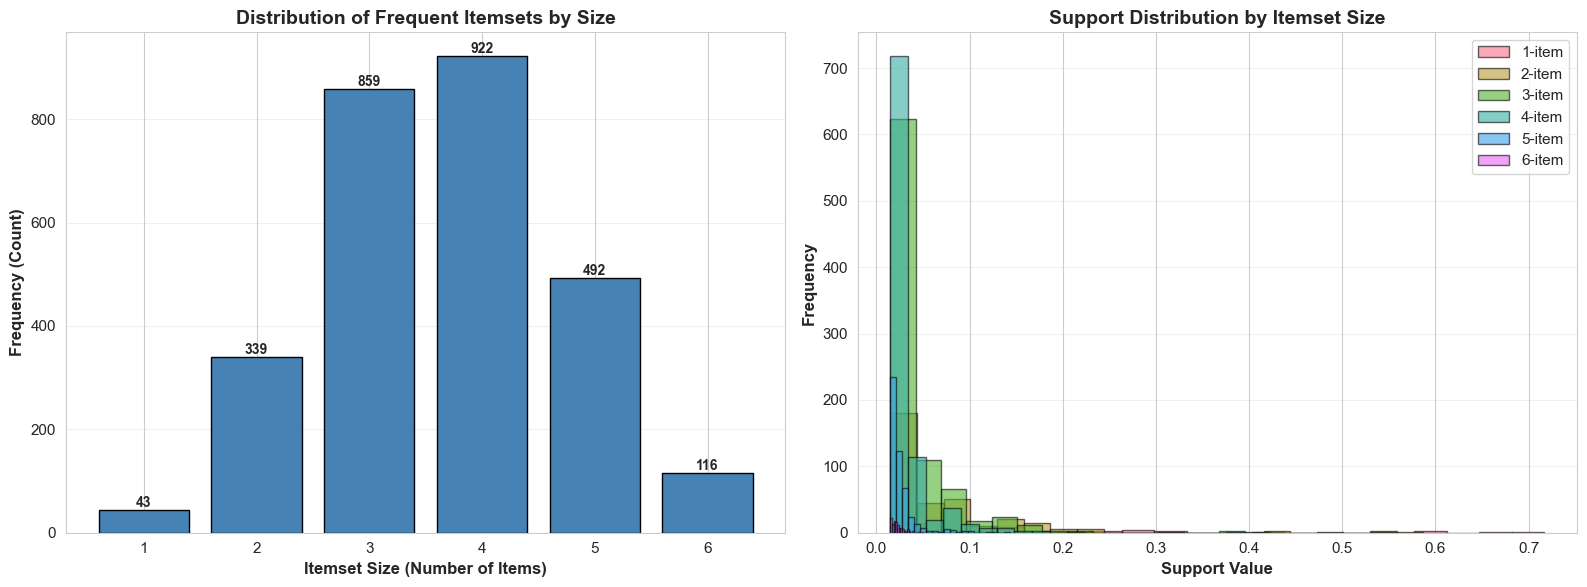

In [15]:
print("\n[Visualization] Itemset size distribution...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bar chart of itemset sizes
ax1 = axes[0]
size_dist_sorted = size_distribution.sort_index()
bars = ax1.bar(size_dist_sorted.index, size_dist_sorted.values, color='steelblue', edgecolor='black')
ax1.set_xlabel('Itemset Size (Number of Items)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency (Count)', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Frequent Itemsets by Size', fontsize=14, fontweight='bold')
ax1.set_xticks(size_dist_sorted.index)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Support distribution by itemset size
ax2 = axes[1]
for size in sorted(frequent_itemsets['length'].unique()):
    subset = frequent_itemsets[frequent_itemsets['length'] == size]['support']
    ax2.hist(subset, bins=20, alpha=0.6, label=f'{size}-item', edgecolor='black')

ax2.set_xlabel('Support Value', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Support Distribution by Itemset Size', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Print top itemsets by size
def print_top_itemsets_by_size(frequent_itemsets, df_encoded, size, top_k=10):
    subset = frequent_itemsets[frequent_itemsets['length'] == size].sort_values('support', ascending=False)
    
    print(f"\n{size}-ITEM PATTERNS (Top {top_k}):")
    print(f"\n{'Rank':<6} {'Support':<10} {'Count':<15} {'Itemset':<60}")
    print("-" * 91)
    
    for idx, row in subset.head(top_k).iterrows():
        rank = idx + 1
        support = row['support']
        count = int(support * len(df_encoded))
        itemset = ', '.join(sorted(list(row['itemsets'])))
        
        # Truncate long itemsets
        if len(itemset) > 55:
            itemset = itemset[:52] + '...'
        
        print(f"{rank:<6} {support:<10.4f} {count:<15,} {itemset}")

In [19]:
print_top_itemsets_by_size(frequent_itemsets, df_encoded, size=1, top_k=10)


1-ITEM PATTERNS (Top 10):

Rank   Support    Count           Itemset                                                     
-------------------------------------------------------------------------------------------
42     0.7168     1,429,463       Weekday
21     0.6778     1,351,707       Neighborhood_Other_Sa
29     0.5870     1,170,667       SJ
8      0.5870     1,170,667       District_San Jose
28     0.4130     823,541         SF
13     0.3270     652,081         Hour_Afternoon
14     0.3000     598,194         Hour_Evening
43     0.2832     564,745         Weekend
38     0.2668     532,077         Type_Theft/Property
26     0.2657     529,956         Q3


In [20]:
print_top_itemsets_by_size(frequent_itemsets, df_encoded, size=2, top_k=10)


2-ITEM PATTERNS (Top 10):

Rank   Support    Count           Itemset                                                     
-------------------------------------------------------------------------------------------
88     0.5870     1,170,667       District_San Jose, SJ
83     0.5581     1,113,041       District_San Jose, Neighborhood_Other_Sa
239    0.5581     1,113,041       Neighborhood_Other_Sa, SJ
252    0.4824     962,094         Neighborhood_Other_Sa, Weekday
342    0.4157     829,056         SJ, Weekday
101    0.4157     829,056         District_San Jose, Weekday
328    0.3011     600,407         SF, Weekday
152    0.2421     482,730         Hour_Afternoon, Weekday
245    0.2227     444,137         Neighborhood_Other_Sa, Type_Disturbance/Suspicious
94     0.2209     440,483         District_San Jose, Type_Disturbance/Suspicious


In [21]:
print_top_itemsets_by_size(frequent_itemsets, df_encoded, size=3, top_k=10)


3-ITEM PATTERNS (Top 10):

Rank   Support    Count           Itemset                                                     
-------------------------------------------------------------------------------------------
506    0.5581     1,113,041       District_San Jose, Neighborhood_Other_Sa, SJ
580    0.4157     829,056         District_San Jose, SJ, Weekday
1030   0.3947     787,079         Neighborhood_Other_Sa, SJ, Weekday
519    0.3947     787,079         District_San Jose, Neighborhood_Other_Sa, Weekday
573    0.2209     440,483         District_San Jose, SJ, Type_Disturbance/Suspicious
512    0.2111     420,931         District_San Jose, Neighborhood_Other_Sa, Type_Distu...
1023   0.2111     420,931         Neighborhood_Other_Sa, SJ, Type_Disturbance/Suspicious
436    0.1854     369,748         District_San Jose, Hour_Afternoon, SJ
454    0.1830     364,904         District_San Jose, Hour_Evening, SJ
673    0.1755     350,015         Hour_Afternoon, Neighborhood_Other_Sa, SJ


In [22]:
print_top_itemsets_by_size(frequent_itemsets, df_encoded, size=4, top_k=10)


4-ITEM PATTERNS (Top 10):

Rank   Support    Count           Itemset                                                     
-------------------------------------------------------------------------------------------
1530   0.3947     787,079         District_San Jose, Neighborhood_Other_Sa, SJ, Weekday
1523   0.2111     420,931         District_San Jose, Neighborhood_Other_Sa, SJ, Type_D...
1288   0.1755     350,015         District_San Jose, Hour_Afternoon, Neighborhood_Othe...
1339   0.1746     348,099         District_San Jose, Hour_Evening, Neighborhood_Other_...
1531   0.1635     325,962         District_San Jose, Neighborhood_Other_Sa, SJ, Weekend
1651   0.1505     300,149         District_San Jose, SJ, Type_Disturbance/Suspicious, ...
1495   0.1489     296,925         District_San Jose, Neighborhood_Other_Sa, Q3, SJ
1484   0.1463     291,749         District_San Jose, Neighborhood_Other_Sa, Q2, SJ
2074   0.1435     286,112         Neighborhood_Other_Sa, SJ, Type_Disturbance/Suspi

In [23]:
print_top_itemsets_by_size(frequent_itemsets, df_encoded, size=5, top_k=10)


5-ITEM PATTERNS (Top 10):

Rank   Support    Count           Itemset                                                     
-------------------------------------------------------------------------------------------
2469   0.1435     286,112         District_San Jose, Neighborhood_Other_Sa, SJ, Type_D...
2215   0.1296     258,364         District_San Jose, Hour_Afternoon, Neighborhood_Othe...
2269   0.1193     237,918         District_San Jose, Hour_Evening, Neighborhood_Other_...
2426   0.1048     208,935         District_San Jose, Neighborhood_Other_Sa, Q3, SJ, We...
2406   0.1028     205,081         District_San Jose, Neighborhood_Other_Sa, Q2, SJ, We...
2387   0.0980     195,463         District_San Jose, Neighborhood_Other_Sa, Q1, SJ, We...
2322   0.0958     191,142         District_San Jose, Hour_Morning, Neighborhood_Other_...
2445   0.0891     177,600         District_San Jose, Neighborhood_Other_Sa, Q4, SJ, We...
2477   0.0837     166,998         District_San Jose, Neighborhood

In [24]:
print_top_itemsets_by_size(frequent_itemsets, df_encoded, size=6, top_k=10)


6-ITEM PATTERNS (Top 10):

Rank   Support    Count           Itemset                                                     
-------------------------------------------------------------------------------------------
2698   0.0505     100,735         District_San Jose, Hour_Evening, Neighborhood_Other_...
2677   0.0440     87,648          District_San Jose, Hour_Afternoon, Neighborhood_Othe...
2749   0.0393     78,301          District_San Jose, Neighborhood_Other_Sa, Q3, SJ, Ty...
2740   0.0382     76,214          District_San Jose, Neighborhood_Other_Sa, Q2, SJ, Ty...
2762   0.0348     69,348          District_San Jose, Neighborhood_Other_Sa, SJ, Saturd...
2731   0.0346     68,997          District_San Jose, Neighborhood_Other_Sa, Q1, SJ, Ty...
2667   0.0335     66,757          District_San Jose, Hour_Afternoon, Neighborhood_Othe...
2690   0.0332     66,116          District_San Jose, Hour_Evening, Neighborhood_Other_...
2669   0.0331     66,104          District_San Jose, Hour_Afterno

## Section 3 Summary

**Frequent Itemsets Discovered:** 2,771 patterns

**Key Insights:**

1. **Temporal Dominance:**
   - Weekday appears in 71.7% of all incidents
   - Afternoon/Evening hours show high frequency
   - Quarter patterns (Q1-Q4) distributed evenly

2. **Geographic Concentration:**
   - San Jose represents 58.7% of incidents (majority)
   - District-level patterns show clear clustering
   - Neighborhood patterns reveal hotspot areas

3. **Incident Type Patterns:**
   - Theft/Property (26.7%) and Disturbance/Suspicious (26.4%) dominate
   - Violent incidents at 7.5% suggest targeted intervention opportunities
   - Non-Criminal/Admin incidents (10.2%) indicate service call patterns

4. **Pattern Complexity:**
   - 86% of patterns involve 3+ items (multi-dimensional relationships)
   - 4-item patterns most common (33.3%) - ideal for actionable rules
   - 6-item patterns (4.2%) capture highly specific scenarios

---

In [26]:
print("\n[CHECKPOINT] Saving frequent itemsets...")

# Save to CSV for reference
output_path = '../data/processed/frequent_itemsets.csv'
frequent_itemsets.to_csv(output_path, index=False)
print(f"   Frequent itemsets saved to: {output_path}")

# Display statistics
print(f"\n   Total patterns saved: {len(frequent_itemsets):,}")
print(f"   Ready for association rule generation")


[CHECKPOINT] Saving frequent itemsets...
   Frequent itemsets saved to: ../data/processed/frequent_itemsets.csv

   Total patterns saved: 2,771
   Ready for association rule generation


## 4. Association Rule Generation

**Objective:** Generate predictive IF-THEN rules from frequent itemsets to discover actionable incident patterns.

**What are Association Rules?**
- Rules derived from frequent itemsets showing probabilistic relationships
- Format: {Antecedent} → {Consequent}
- Example: {Weekday, Morning, District_Downtown} → {Type_Traffic/Vehicle}
- Interpretation: "When incidents occur on weekday mornings in downtown, there's a high probability it's a traffic incident"

**Rule Generation Process:**
1. Take each frequent itemset of size n (n >= 2)
2. Generate all possible splits into antecedent and consequent
3. Calculate metrics: support, confidence, lift, conviction
4. Filter by minimum thresholds

**Quality Metrics:**
- **Support:** Frequency of the full pattern (antecedent + consequent)
- **Confidence:** P(Consequent|Antecedent) - Reliability of the rule
- **Lift:** Confidence / P(Consequent) - How much better than random?
- **Conviction:** (1 - P(Consequent)) / (1 - Confidence) - Directional strength

**Filtering Thresholds:**
- **min_confidence = 0.30 (30%):** Rule must be correct at least 30% of the time
- **min_lift = 1.5:** Rule must be 50% better than random chance
- **Reasoning:**
  - 30% confidence: High enough to be actionable, low enough to capture diverse patterns
  - 1.5 lift: Ensures meaningful correlation, filters out weak associations
  - With 2M+ incidents, these thresholds balance statistical significance with practical utility

---

In [46]:
print("\n[Step 1] Generating association rules from frequent itemsets...")
print(f"   Input: {len(frequent_itemsets):,} frequent itemsets")
print(f"   Parameters:")
print(f"      - metric: 'confidence'")
print(f"      - min_threshold: 0.30 (30%)")
print(f"      - Filter: lift >= 1.5")

# Generate rules using mlxtend
rules = association_rules(
    frequent_itemsets, 
    metric="confidence", 
    min_threshold=0.30
)

print(f"\n   Initial rules generated: {len(rules):,}")

# Filter by lift
rules_filtered = rules[rules['lift'] >= 1.5].copy()

print(f"   After lift filter (>= 1.5): {len(rules_filtered):,} rules")


[Step 1] Generating association rules from frequent itemsets...
   Input: 2,771 frequent itemsets
   Parameters:
      - metric: 'confidence'
      - min_threshold: 0.30 (30%)
      - Filter: lift >= 1.5

   Initial rules generated: 12,263
   After lift filter (>= 1.5): 6,216 rules


In [47]:
def deduplicate_rules(rules_df, keep='first', sort_by='confidence', ascending=False, verbose=True):
    """
    Remove redundant association rules that represent the same itemset pattern.
    
    Parameters:
    -----------
    rules_df : pd.DataFrame
        Association rules DataFrame from mlxtend.association_rules()
    keep : str, default 'first'
        Which duplicate to keep ('first' or 'last')
    sort_by : str, default 'confidence'
        Metric to sort by before deduplication ('confidence', 'lift', 'conviction')
    ascending : bool, default False
        Sort order (False = keep highest value)
    verbose : bool, default True
        Print deduplication statistics
    
    Returns:
    --------
    pd.DataFrame
        Deduplicated rules DataFrame
    """
    if verbose:
        print(f"\n[Deduplication] Removing redundant rules...")
        print(f"   Before: {len(rules_df):,} rules")
    
    # Create unique identifier for each itemset
    def get_itemset_signature(row):
        return frozenset(row['antecedents']) | frozenset(row['consequents'])
    
    rules_temp = rules_df.copy()
    rules_temp['_itemset_signature'] = rules_temp.apply(get_itemset_signature, axis=1)
    
    # Count duplicates
    if verbose:
        duplicate_groups = rules_temp.groupby('_itemset_signature').size()
        duplicate_count = (duplicate_groups > 1).sum()
        print(f"   Duplicate itemsets found: {duplicate_count:,}")
    
    # Sort by chosen metric and deduplicate
    rules_dedup = rules_temp.sort_values(sort_by, ascending=ascending).drop_duplicates(
        subset='_itemset_signature', keep=keep
    ).drop(columns=['_itemset_signature'])
    
    if verbose:
        print(f"   After: {len(rules_dedup):,} unique rules")
        print(f"   Removed: {len(rules_df) - len(rules_dedup):,} redundant rules")
    
    return rules_dedup

In [115]:
def filter_trivial_rules(rules_df, verbose=True):
    """
    Remove trivial/obvious rules that provide no actionable insights.
    
    Enhanced to filter:
    - Day name → Weekend/Weekday (definitional)
    - Neighborhood → District (geographic containment)
    - City → City (redundant)
    - District/Neighborhood → City (geographic definitional)
    - Perfect confidence rules with city as consequent
    - City → District (when city has only 1 district - definitional)
    """
    if verbose:
        print(f"\n[Trivial Rule Filtering] Removing obvious patterns...")
        print(f"   Before filtering: {len(rules_df):,} rules")
    
    def is_trivial(row):
        ant = set(row['antecedents'])
        cons = set(row['consequents'])
        
        # Rule 1: Day of week → Weekend/Weekday (definitional)
        weekdays = {'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'}
        weekend_days = {'Saturday', 'Sunday'}
        
        if (ant & weekdays and 'Weekday' in cons):
            return True
        if (ant & weekend_days and 'Weekend' in cons):
            return True
        if (ant & {'Weekday'} and cons & weekdays):
            return True
        if (ant & {'Weekend'} and cons & weekend_days):
            return True
        
        # Rule 2: Neighborhood → District (geographic containment)
        for ant_item in ant:
            if 'Neighborhood_' in ant_item:
                for cons_item in cons:
                    if 'District_' in cons_item:
                        neighborhood_base = ant_item.replace('Neighborhood_', '').replace('_SF', '').replace('_SJ', '')
                        district_base = cons_item.replace('District_', '')
                        if neighborhood_base.lower() in district_base.lower() or district_base.lower() in neighborhood_base.lower():
                            return True
        
        # Rule 3: City → City (redundant)
        if ant & {'SF', 'SJ'} and cons & {'SF', 'SJ'}:
            return True
        
        # Rule 4: Perfect confidence (1.0) with single consequent + day/weekend pattern
        if row['confidence'] == 1.0 and len(cons) == 1:
            if cons & {'Weekend', 'Weekday'}:
                if ant & (weekdays | weekend_days):
                    return True
        
        # Rule 5: Quarter → Quarter (temporal redundancy)
        quarters = {'Q1', 'Q2', 'Q3', 'Q4'}
        if ant & quarters and cons & quarters:
            return True
        
        # Rule 6: District/Neighborhood → City (Geographic Definitional)
        if cons & {'SF', 'SJ'}:
            city_in_consequent = list(cons & {'SF', 'SJ'})[0]
            
            for ant_item in ant:
                if 'District_' in ant_item or 'Neighborhood_' in ant_item:
                    if city_in_consequent == 'SF':
                        sf_districts = ['Bayview', 'Central', 'Ingleside', 'Mission', 'Northern',
                                       'Park', 'Richmond', 'Southern', 'Taraval', 'Tenderloin']
                        if any(dist in ant_item for dist in sf_districts):
                            return True
                        if '_SF' in ant_item:
                            return True
                    elif city_in_consequent == 'SJ':
                        if '_SJ' in ant_item:
                            return True
        
        # Rule 7: Perfect Confidence → City (Usually Trivial)
        if row['confidence'] == 1.0 and cons & {'SF', 'SJ'} and len(cons) == 1:
            has_incident = any('Type_' in str(item) for item in ant)
            has_temporal = any('Hour_' in str(item) for item in ant)
            has_location = any('District_' in str(item) or 'Neighborhood_' in str(item) for item in ant)
            
            if has_location:
                return True
        
        # ===================================================================
        # NEW RULE 8: City → District (Single District Tautology)
        # ===================================================================
        # If city predicts its only district (e.g., SJ → District_San Jose)
        # This is definitional when city has only 1 district
        
        if ant & {'SF', 'SJ'} and len(ant) == 1:
            for cons_item in cons:
                if 'District_' in cons_item:
                    # SJ only has "District_San Jose"
                    if 'SJ' in ant and 'District_San Jose' in cons_item:
                        return True
                    # If SF predicts a single district without other context
                    # (Less likely to be trivial since SF has 10 districts)
        
        # ===================================================================
        # NEW RULE 9: District → City (Single District Reverse Tautology)
        # ===================================================================
        # If district predicts city with perfect confidence (definitional)
        
        if row['confidence'] == 1.0:
            for ant_item in ant:
                if 'District_' in ant_item:
                    # District_San Jose → SJ (obvious)
                    if 'District_San Jose' in ant_item and cons & {'SJ'}:
                        return True
                    # SF districts → SF (already covered by Rule 6, but redundant check)
                    sf_districts = ['Bayview', 'Central', 'Ingleside', 'Mission', 'Northern',
                                   'Park', 'Richmond', 'Southern', 'Taraval', 'Tenderloin']
                    if any(dist in ant_item for dist in sf_districts) and cons & {'SF'}:
                        if len(ant) == 1 and len(cons) == 1:  # Pure district → city rule
                            return True
        
        return False
    
    # Apply filter
    rules_nontrivial = rules_df[~rules_df.apply(is_trivial, axis=1)].copy()
    
    if verbose:
        removed_count = len(rules_df) - len(rules_nontrivial)
        print(f"   After filtering: {len(rules_nontrivial):,} rules")
        print(f"   Trivial rules removed: {removed_count:,} ({100*removed_count/len(rules_df):.1f}%)")
        
        if removed_count > 0:
            trivial_rules = rules_df[rules_df.apply(is_trivial, axis=1)]
            print(f"\n   Examples of filtered trivial rules:")
            for idx, row in trivial_rules.head(3).iterrows():
                ant = ', '.join(sorted(list(row['antecedents'])))
                cons = ', '.join(sorted(list(row['consequents'])))
                print(f"      • {ant} → {cons}")
    
    return rules_nontrivial

In [116]:
def filter_non_actionable_rules(rules_df, verbose=True):
    """
    Remove non-actionable rules that are statistically valid but provide no operational value.
    
    **What Makes a Rule Non-Actionable?**
    
    Non-actionable rules are patterns that:
    1. Cannot inform resource deployment decisions
    2. Do not help predict WHERE/WHEN/WHAT to focus on
    3. Only identify WHICH CITY an incident belongs to (without location context)
    
    **Examples:**
    
    ❌ Non-Actionable:
       • Hour_Evening, Type_Theft → SF
         (Can't deploy differently - you already know the incident type and time)
       
       • Weekday, Type_Violent → SJ
         (Doesn't tell you WHERE in SJ or specific timing)
    
    ✅ Actionable:
       • Hour_Evening, SJ → Type_Disturbance
         (Predicts incident type - can prepare appropriate units)
       
       • Weekday, Type_Theft → District_Tenderloin
         (Predicts hotspot - can deploy patrols proactively)
       
       • Hour_Night, District_Central → Type_Violent
         (Time + location → incident type - actionable patrol strategy)
    
    **Filtering Logic:**
    - If consequent is ONLY city (SF/SJ) AND antecedent lacks location info
    - These rules don't help decide WHERE to deploy or WHAT to prepare for
    
    Parameters:
    -----------
    rules_df : pd.DataFrame
        Association rules DataFrame (after trivial filtering)
    verbose : bool, default True
        Print filtering statistics
    
    Returns:
    --------
    pd.DataFrame
        Rules with actionable deployment insights only
    """
    if verbose:
        print(f"\n[Non-Actionable Rule Filtering] Removing operationally useless patterns...")
        print(f"   Before filtering: {len(rules_df):,} rules")
        print(f"\n   Definition: Non-actionable rules cannot inform:")
        print(f"      • WHERE to deploy resources")
        print(f"      • WHAT incident types to prepare for")
        print(f"      • WHEN to increase staffing")
    
    def is_non_actionable(row):
        ant = set(row['antecedents'])
        cons = set(row['consequents'])
        
        # ===================================================================
        # RULE 1: Predicting City Without Location Context (Non-Actionable)
        # ===================================================================
        # If consequent is ONLY city identification (SF or SJ)
        # AND antecedent does NOT contain location information
        # → Cannot deploy based on this rule
        
        if cons & {'SF', 'SJ'} and len(cons) == 1:
            has_location = any('District_' in str(item) or 'Neighborhood_' in str(item) 
                              for item in ant)
            
            # If no location in antecedent, city prediction is not actionable
            if not has_location:
                return True
        
        return False
    
    # Apply filter
    rules_actionable = rules_df[~rules_df.apply(is_non_actionable, axis=1)].copy()
    
    if verbose:
        removed_count = len(rules_df) - len(rules_actionable)
        print(f"\n   After filtering: {len(rules_actionable):,} actionable rules")
        print(f"   Non-actionable rules removed: {removed_count:,} ({100*removed_count/len(rules_df):.1f}%)")
        
        if removed_count > 0:
            non_actionable_rules = rules_df[rules_df.apply(is_non_actionable, axis=1)]
            print(f"\n   Examples of filtered non-actionable rules:")
            for idx, row in non_actionable_rules.head(3).iterrows():
                ant = ', '.join(sorted(list(row['antecedents'])))
                cons = ', '.join(sorted(list(row['consequents'])))
                print(f"      • {ant} → {cons}")
                print(f"        (Can't deploy based on city prediction alone)")
    
    return rules_actionable

In [117]:
# Deduplicate rules (keeps highest confidence version of each unique itemset)
rules_filtered = deduplicate_rules(rules_filtered, sort_by='confidence', ascending=False)

# Filter out trivial rules
rules_filtered = filter_trivial_rules(rules_filtered, verbose=True)

# Filter out non-actionable rules
rules_filtered = filter_non_actionable_rules(rules_filtered, verbose=True)

# Add rule length columns for analysis
rules_filtered['antecedent_len'] = rules_filtered['antecedents'].apply(lambda x: len(x))
rules_filtered['consequent_len'] = rules_filtered['consequents'].apply(lambda x: len(x))

print(f"\n[Step 2] Rule statistics:")
print(f"   Total rules: {len(rules_filtered):,}")
print(f"   Support range: {rules_filtered['support'].min():.4f} to {rules_filtered['support'].max():.4f}")
print(f"   Confidence range: {rules_filtered['confidence'].min():.4f} to {rules_filtered['confidence'].max():.4f}")
print(f"   Lift range: {rules_filtered['lift'].min():.2f} to {rules_filtered['lift'].max():.2f}")
print(f"   Conviction range: {rules_filtered['conviction'].min():.2f} to {rules_filtered['conviction'].max():.2f}")


[Deduplication] Removing redundant rules...
   Before: 626 rules
   Duplicate itemsets found: 0
   After: 626 unique rules
   Removed: 0 redundant rules

[Trivial Rule Filtering] Removing obvious patterns...
   Before filtering: 626 rules
   After filtering: 625 rules
   Trivial rules removed: 1 (0.2%)

   Examples of filtered trivial rules:
      • SJ → District_San Jose

[Non-Actionable Rule Filtering] Removing operationally useless patterns...
   Before filtering: 625 rules

   Definition: Non-actionable rules cannot inform:
      • WHERE to deploy resources
      • WHAT incident types to prepare for
      • WHEN to increase staffing

   After filtering: 625 actionable rules
   Non-actionable rules removed: 0 (0.0%)

[Step 2] Rule statistics:
   Total rules: 625
   Support range: 0.0150 to 0.5581
   Confidence range: 0.3134 to 1.0000
   Lift range: 1.50 to 14.19
   Conviction range: 1.15 to inf


In [118]:
# Display sample rules
print(f"\n[Step 3] Sample association rules (first 5):")
sample_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
for idx, row in rules_filtered.head(5).iterrows():
    ant = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    print(f"\n   Rule {idx+1}:")
    print(f"      {ant}")
    print(f"      → {cons}")
    print(f"      Support: {row['support']:.4f} | Confidence: {row['confidence']:.4f} | Lift: {row['lift']:.2f}")


[Step 3] Sample association rules (first 5):

   Rule 6962:
      Hour_Morning, Thursday, Neighborhood_Other_Sa, SJ
      → District_San Jose
      Support: 0.0191 | Confidence: 1.0000 | Lift: 1.70

   Rule 2921:
      Neighborhood_Other_Sa, Thursday, SJ
      → District_San Jose
      Support: 0.0777 | Confidence: 1.0000 | Lift: 1.70

   Rule 6906:
      Hour_Morning, Q2, Neighborhood_Other_Sa, SJ
      → District_San Jose
      Support: 0.0323 | Confidence: 1.0000 | Lift: 1.70

   Rule 51:
      Type_Alarm
      → District_San Jose
      Support: 0.0314 | Confidence: 1.0000 | Lift: 1.70

   Rule 6948:
      Hour_Morning, Saturday, Neighborhood_Other_Sa, SJ
      → District_San Jose
      Support: 0.0159 | Confidence: 1.0000 | Lift: 1.70


In [119]:
# Antecedent length distribution
ant_dist = rules_filtered['antecedent_len'].value_counts().sort_index()
print(f"\nAntecedent Length Distribution:")
print(f"\n{'Length':<12} {'Count':<12} {'Percentage':<15}")
print("-" * 39)
for length, count in ant_dist.items():
    pct = 100 * count / len(rules_filtered)
    print(f"{length} items{' '*(6-len(str(length)))} {count:<12,} {pct:>5.1f}%")

# Consequent length distribution
cons_dist = rules_filtered['consequent_len'].value_counts().sort_index()
print(f"\n\nConsequent Length Distribution:")
print(f"\n{'Length':<12} {'Count':<12} {'Percentage':<15}")
print("-" * 39)
for length, count in cons_dist.items():
    pct = 100 * count / len(rules_filtered)
    print(f"{length} items{' '*(6-len(str(length)))} {count:<12,} {pct:>5.1f}%")


Antecedent Length Distribution:

Length       Count        Percentage     
---------------------------------------
1 items      16             2.6%
2 items      81            13.0%
3 items      248           39.7%
4 items      211           33.8%
5 items      69            11.0%


Consequent Length Distribution:

Length       Count        Percentage     
---------------------------------------
1 items      587           93.9%
2 items      38             6.1%


In [120]:
# Rule complexity distribution
print(f"\n\nRule Complexity (Total Items):")
rules_filtered['total_len'] = rules_filtered['antecedent_len'] + rules_filtered['consequent_len']
complexity_dist = rules_filtered['total_len'].value_counts().sort_index()
print(f"\n{'Total Items':<15} {'Count':<12} {'Percentage':<15}")
print("-" * 42)
for length, count in complexity_dist.items():
    pct = 100 * count / len(rules_filtered)
    print(f"{length} items{' '*(9-len(str(length)))} {count:<12,} {pct:>5.1f}%")

print(f"\n\nKey Observations:")
print(f"   - Most rules have {ant_dist.idxmax()} items in antecedent")
print(f"   - Most rules predict {cons_dist.idxmax()} item in consequent")
print(f"   - Average rule complexity: {rules_filtered['total_len'].mean():.1f} items")



Rule Complexity (Total Items):

Total Items     Count        Percentage     
------------------------------------------
2 items         13             2.1%
3 items         60             9.6%
4 items         261           41.8%
5 items         222           35.5%
6 items         69            11.0%


Key Observations:
   - Most rules have 3 items in antecedent
   - Most rules predict 1 item in consequent
   - Average rule complexity: 4.4 items


In [121]:
# Sort by lift and display top 20
top_rules = rules_filtered.nlargest(20, 'lift')

print(f"\nTop 20 Rules (Highest Lift):")
print(f"\n{'Rank':<6} {'Lift':<8} {'Conf':<8} {'Support':<10} {'Rule':<60}")
print("-" * 92)

for idx, row in top_rules.iterrows():
    rank = len(top_rules) - len(top_rules[top_rules['lift'] > row['lift']])
    ant = ', '.join(sorted(list(row['antecedents'])))
    cons = ', '.join(sorted(list(row['consequents'])))
    rule_str = f"{ant} → {cons}"
    
    print(f"{rank:<6} {row['lift']:<8.2f} {row['confidence']:<8.4f} {row['support']:<10.4f} {rule_str}")


Top 20 Rules (Highest Lift):

Rank   Lift     Conf     Support    Rule                                                        
--------------------------------------------------------------------------------------------
20     14.19    0.7131   0.0269     Neighborhood_South of Market_SF → District_Southern
19     14.15    0.7113   0.0198     Neighborhood_South of Market_SF, Weekday → District_Southern
18     9.90     0.5913   0.0168     Neighborhood_Financial District/South Beach_SF → District_Central
17     2.26     0.6038   0.0205     Hour_Evening, Neighborhood_Other_Sa, SF → Type_Theft/Property
16     2.23     0.5940   0.0343     District_Northern → Type_Theft/Property
15     2.20     0.5878   0.0351     District_Central → Type_Theft/Property
14     2.20     0.5871   0.0242     District_Northern, Weekday → Type_Theft/Property
13     2.20     0.5858   0.0250     District_Central, Weekday → Type_Theft/Property
12     2.12     0.5649   0.0160     Neighborhood_Financial District/South 


VISUALIZATION 1: SUPPORT VS CONFIDENCE


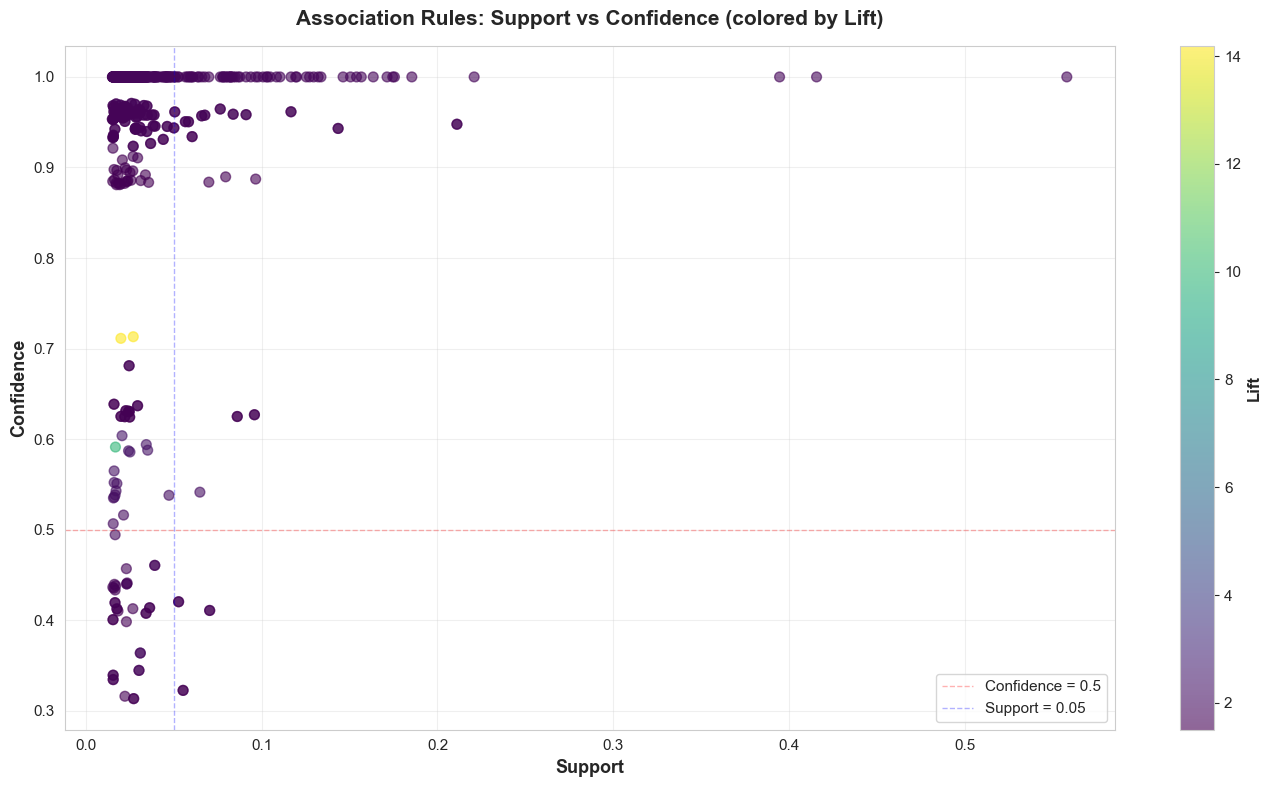


Key Observations:
   • Total rules plotted: 625
   • Support range: 0.0150 to 0.5581
   • Confidence range: 0.3134 to 1.0000
   • Highest lift rules (Lift > 10): 2


In [122]:
print("\n" + "="*80)
print("VISUALIZATION 1: SUPPORT VS CONFIDENCE")
print("="*80)

fig, ax = plt.subplots(figsize=(14, 8))

scatter = ax.scatter(rules_filtered['support'], rules_filtered['confidence'], 
                     c=rules_filtered['lift'], cmap='viridis', alpha=0.6, s=50)
ax.set_xlabel('Support', fontsize=13, fontweight='bold')
ax.set_ylabel('Confidence', fontsize=13, fontweight='bold')
ax.set_title('Association Rules: Support vs Confidence (colored by Lift)', 
             fontsize=15, fontweight='bold', pad=15)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lift', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Add reference lines
ax.axhline(0.5, color='red', linestyle='--', alpha=0.3, linewidth=1, label='Confidence = 0.5')
ax.axvline(0.05, color='blue', linestyle='--', alpha=0.3, linewidth=1, label='Support = 0.05')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"\nKey Observations:")
print(f"   • Total rules plotted: {len(rules_filtered):,}")
print(f"   • Support range: {rules_filtered['support'].min():.4f} to {rules_filtered['support'].max():.4f}")
print(f"   • Confidence range: {rules_filtered['confidence'].min():.4f} to {rules_filtered['confidence'].max():.4f}")
print(f"   • Highest lift rules (Lift > 10): {len(rules_filtered[rules_filtered['lift'] > 10]):,}")


VISUALIZATION 2: LIFT DISTRIBUTION


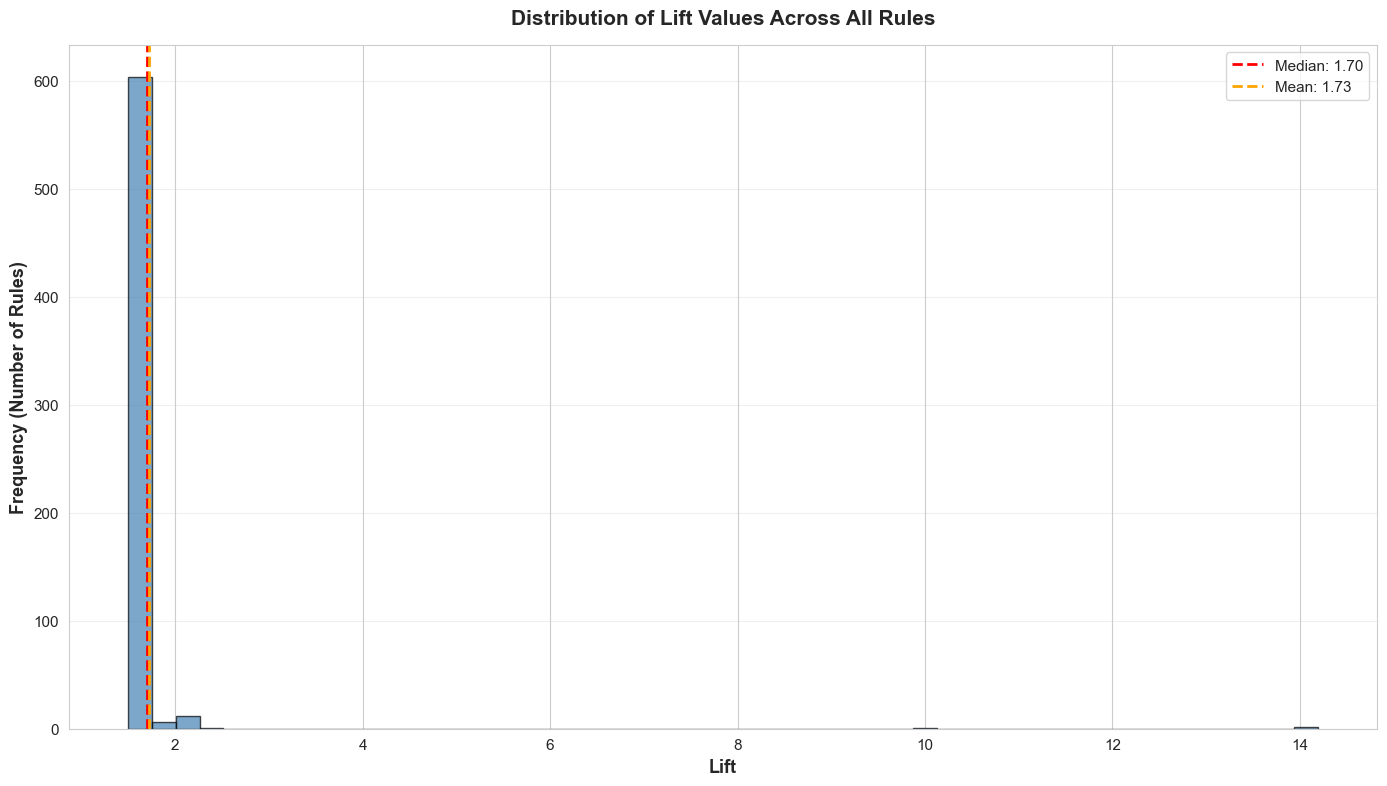


Lift Statistics:
   • Minimum: 1.50
   • 25th percentile: 1.63
   • Median: 1.70
   • 75th percentile: 1.70
   • Maximum: 14.19
   • Mean: 1.73
   • Standard deviation: 0.78


In [123]:
print("\n" + "="*80)
print("VISUALIZATION 2: LIFT DISTRIBUTION")
print("="*80)

fig, ax = plt.subplots(figsize=(14, 8))

ax.hist(rules_filtered['lift'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Lift', fontsize=13, fontweight='bold')
ax.set_ylabel('Frequency (Number of Rules)', fontsize=13, fontweight='bold')
ax.set_title('Distribution of Lift Values Across All Rules', 
             fontsize=15, fontweight='bold', pad=15)

# Add statistical lines
median_lift = rules_filtered['lift'].median()
mean_lift = rules_filtered['lift'].mean()
ax.axvline(median_lift, color='red', linestyle='--', 
           linewidth=2, label=f'Median: {median_lift:.2f}')
ax.axvline(mean_lift, color='orange', linestyle='--', 
           linewidth=2, label=f'Mean: {mean_lift:.2f}')

ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLift Statistics:")
print(f"   • Minimum: {rules_filtered['lift'].min():.2f}")
print(f"   • 25th percentile: {rules_filtered['lift'].quantile(0.25):.2f}")
print(f"   • Median: {median_lift:.2f}")
print(f"   • 75th percentile: {rules_filtered['lift'].quantile(0.75):.2f}")
print(f"   • Maximum: {rules_filtered['lift'].max():.2f}")
print(f"   • Mean: {mean_lift:.2f}")
print(f"   • Standard deviation: {rules_filtered['lift'].std():.2f}")


VISUALIZATION 3: CONFIDENCE DISTRIBUTION


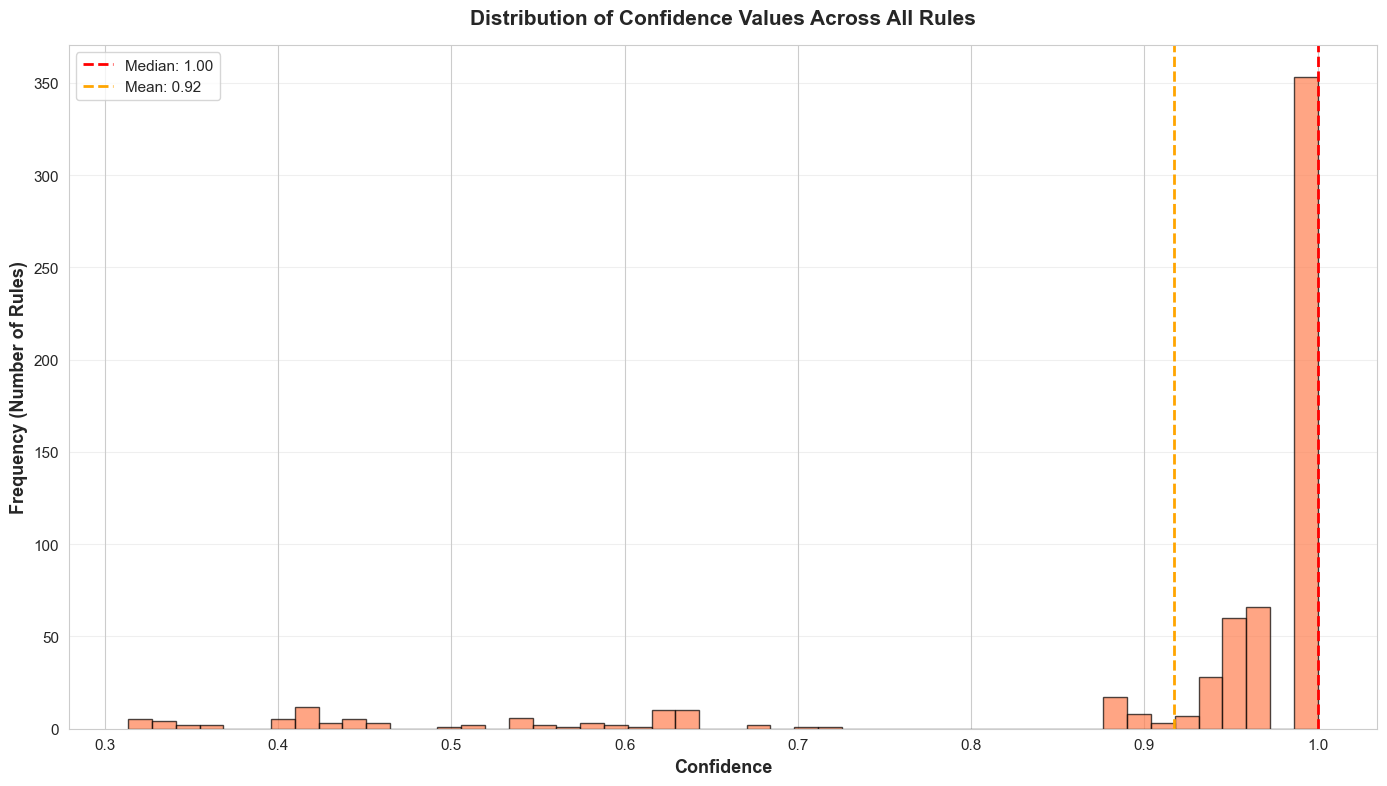


Confidence Statistics:
   • Minimum: 0.3134
   • 25th percentile: 0.9506
   • Median: 1.0000
   • 75th percentile: 1.0000
   • Maximum: 1.0000
   • Mean: 0.9171


In [124]:
print("\n" + "="*80)
print("VISUALIZATION 3: CONFIDENCE DISTRIBUTION")
print("="*80)

fig, ax = plt.subplots(figsize=(14, 8))

ax.hist(rules_filtered['confidence'], bins=50, color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('Confidence', fontsize=13, fontweight='bold')
ax.set_ylabel('Frequency (Number of Rules)', fontsize=13, fontweight='bold')
ax.set_title('Distribution of Confidence Values Across All Rules', 
             fontsize=15, fontweight='bold', pad=15)

# Add statistical lines
median_conf = rules_filtered['confidence'].median()
mean_conf = rules_filtered['confidence'].mean()
ax.axvline(median_conf, color='red', linestyle='--', 
           linewidth=2, label=f'Median: {median_conf:.2f}')
ax.axvline(mean_conf, color='orange', linestyle='--', 
           linewidth=2, label=f'Mean: {mean_conf:.2f}')

ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConfidence Statistics:")
print(f"   • Minimum: {rules_filtered['confidence'].min():.4f}")
print(f"   • 25th percentile: {rules_filtered['confidence'].quantile(0.25):.4f}")
print(f"   • Median: {median_conf:.4f}")
print(f"   • 75th percentile: {rules_filtered['confidence'].quantile(0.75):.4f}")
print(f"   • Maximum: {rules_filtered['confidence'].max():.4f}")
print(f"   • Mean: {mean_conf:.4f}")


VISUALIZATION 4: RULE COMPLEXITY VS AVERAGE LIFT


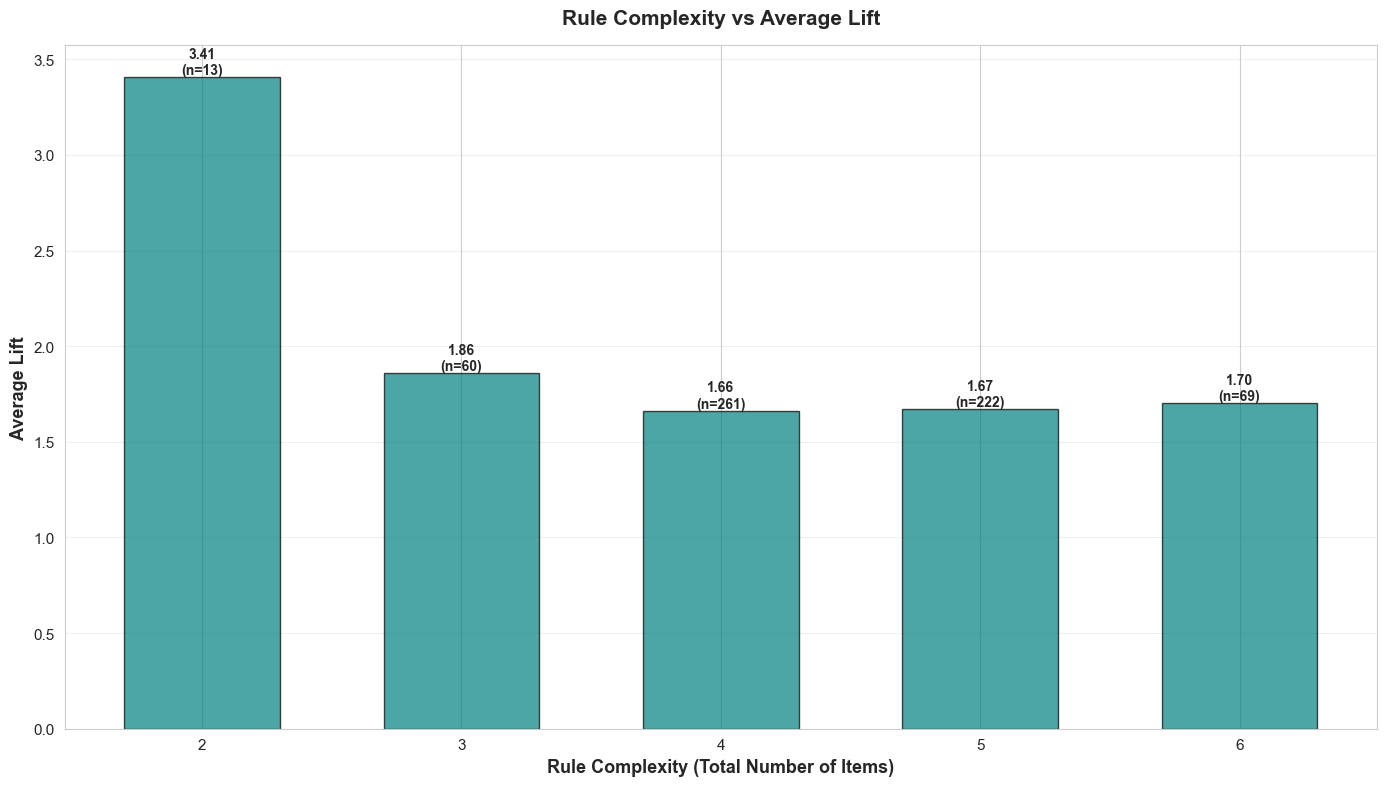


Complexity Analysis:
   • 2 items: 13 rules (2.1%) - Avg Lift: 3.41
   • 3 items: 60 rules (9.6%) - Avg Lift: 1.86
   • 4 items: 261 rules (41.8%) - Avg Lift: 1.66
   • 5 items: 222 rules (35.5%) - Avg Lift: 1.67
   • 6 items: 69 rules (11.0%) - Avg Lift: 1.70


In [125]:
print("\n" + "="*80)
print("VISUALIZATION 4: RULE COMPLEXITY VS AVERAGE LIFT")
print("="*80)

fig, ax = plt.subplots(figsize=(14, 8))

# Calculate average lift by complexity
complexity_lift = rules_filtered.groupby('total_len')['lift'].mean().sort_index()
complexity_count = rules_filtered.groupby('total_len').size()

bars = ax.bar(complexity_lift.index, complexity_lift.values, 
              color='teal', edgecolor='black', alpha=0.7, width=0.6)
ax.set_xlabel('Rule Complexity (Total Number of Items)', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Lift', fontsize=13, fontweight='bold')
ax.set_title('Rule Complexity vs Average Lift', 
             fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(complexity_lift.index)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, complexity_count):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}\n(n={count})',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nComplexity Analysis:")
for complexity, avg_lift in complexity_lift.items():
    count = complexity_count[complexity]
    pct = 100 * count / len(rules_filtered)
    print(f"   • {complexity} items: {count:,} rules ({pct:.1f}%) - Avg Lift: {avg_lift:.2f}")

In [126]:
print("\n" + "="*80)
print("RULE CATEGORIZATION BY PATTERN TYPE")
print("="*80)

# Helper function to extract item types from rules
def categorize_rule(row):
    """Categorize rule based on antecedent and consequent items."""
    ant_items = list(row['antecedents'])
    cons_items = list(row['consequents'])
    all_items = ant_items + cons_items
    
    # Check for different item types
    has_temporal = any('Hour_' in str(item) or item in ['Weekday', 'Weekend'] 
                       or item in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                   'Friday', 'Saturday', 'Sunday'] 
                       or item in ['Q1', 'Q2', 'Q3', 'Q4'] 
                       for item in all_items)
    has_incident = any('Type_' in str(item) for item in all_items)
    has_district = any('District_' in str(item) for item in all_items)
    has_neighborhood = any('Neighborhood_' in str(item) for item in all_items)
    has_city = any(item in ['SF', 'SJ'] for item in all_items)
    
    # Categorize based on combinations
    if has_temporal and has_incident and (has_district or has_neighborhood):
        return 'Temporal-Incident-Location'
    elif has_temporal and has_incident:
        return 'Temporal-Incident'
    elif has_temporal and (has_district or has_neighborhood):
        return 'Temporal-Location'
    elif has_incident and (has_district or has_neighborhood):
        return 'Incident-Location'
    elif has_district and has_neighborhood:
        return 'District-Neighborhood'
    elif has_city:
        return 'City-Specific'
    else:
        return 'Other'

# Apply categorization
print("   Categorizing rules...")
rules_filtered['category'] = rules_filtered.apply(categorize_rule, axis=1)

# Count rules by category
category_counts = rules_filtered['category'].value_counts()

print(f"\nRule Categories:")
print(f"\n{'Category':<35} {'Count':<12} {'Percentage':<15}")
print("-" * 62)

for category, count in category_counts.items():
    pct = 100 * count / len(rules_filtered)
    print(f"{category:<35} {count:<12,} {pct:>5.1f}%")

print(f"\n{'Total':<35} {len(rules_filtered):<12,} 100.0%")


RULE CATEGORIZATION BY PATTERN TYPE
   Categorizing rules...

Rule Categories:

Category                            Count        Percentage     
--------------------------------------------------------------
Temporal-Incident-Location          353           56.5%
Temporal-Location                   224           35.8%
Incident-Location                   29             4.6%
Temporal-Incident                   16             2.6%
District-Neighborhood               3              0.5%

Total                               625          100.0%



VISUALIZATION 5: RULE CATEGORY DISTRIBUTION


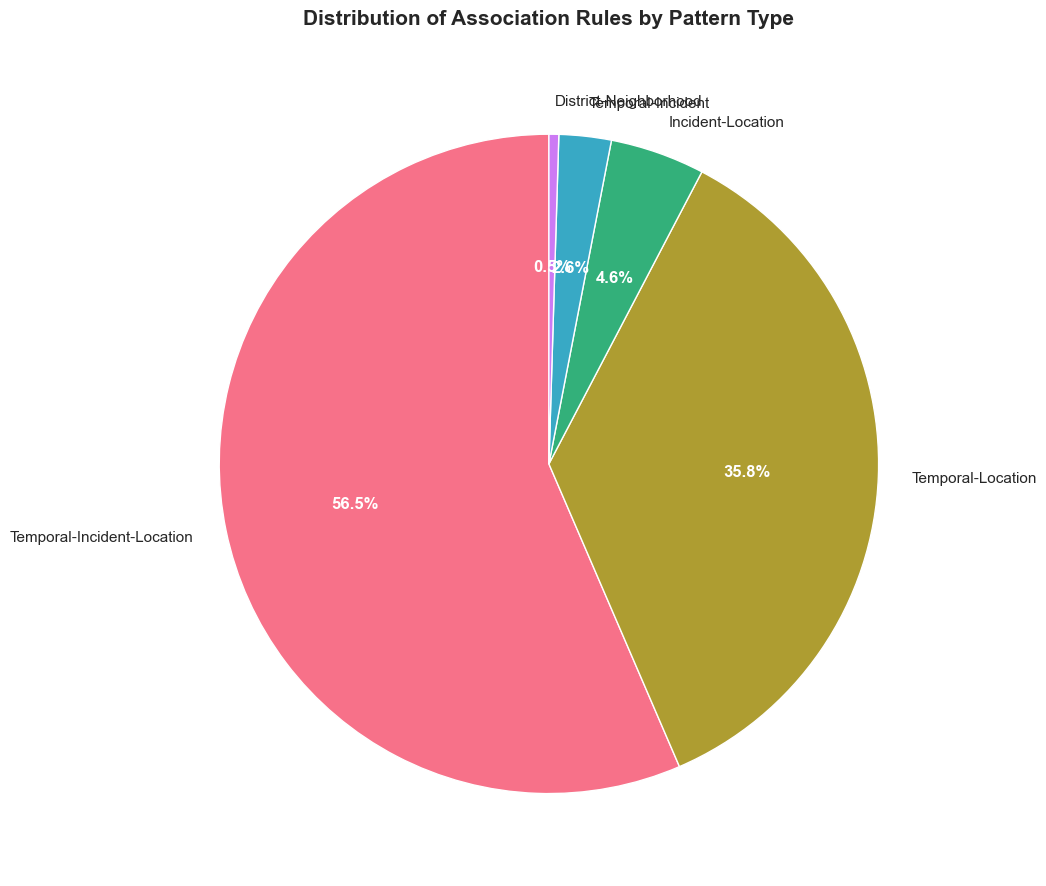


Top Pattern Types:
   1. Temporal-Incident-Location: 353 rules (56.5%)
   2. Temporal-Location: 224 rules (35.8%)
   3. Incident-Location: 29 rules (4.6%)
   4. Temporal-Incident: 16 rules (2.6%)
   5. District-Neighborhood: 3 rules (0.5%)


In [127]:
print("\n" + "="*80)
print("VISUALIZATION 5: RULE CATEGORY DISTRIBUTION")
print("="*80)

fig, ax = plt.subplots(figsize=(14, 9))

# Get top 6 categories, group rest as "Other"
top_n = 6
top_categories = category_counts.head(top_n)
other_count = category_counts[top_n:].sum()

if other_count > 0:
    plot_data = pd.concat([top_categories, pd.Series({'Other': other_count})])
else:
    plot_data = top_categories

# Create pie chart
colors = sns.color_palette('husl', len(plot_data))
wedges, texts, autotexts = ax.pie(plot_data.values, labels=plot_data.index, autopct='%1.1f%%',
                                    colors=colors, startangle=90, textprops={'fontsize': 11})

# Bold the percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

ax.set_title('Distribution of Association Rules by Pattern Type', 
             fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\nTop Pattern Types:")
for idx, (cat, count) in enumerate(category_counts.head(5).items(), 1):
    pct = 100 * count / len(rules_filtered)
    print(f"   {idx}. {cat}: {count:,} rules ({pct:.1f}%)")

In [128]:
# need a function to print the below but calling it for diff categories
def print_top_rules_by_category(rules_filtered, category, top_k=3):
    cat_rules = rules_filtered[rules_filtered['category'] == category].nlargest(top_k, 'lift')
    
    print(f"\n{'='*80}")
    print(f"{category.upper()} (Top {top_k} by Lift)")
    print(f"{'='*80}")
    
    for rank, (idx, row) in enumerate(cat_rules.iterrows(), 1):
        ant = ', '.join(sorted(list(row['antecedents'])))
        cons = ', '.join(sorted(list(row['consequents'])))
        
        print(f"\n   [{rank}] Rule:")
        print(f"       IF: {ant}")
        print(f"       THEN: {cons}")
        print(f"       Metrics: Lift={row['lift']:.2f} | Confidence={row['confidence']:.4f} | Support={row['support']:.4f}")

In [129]:
print_top_rules_by_category(rules_filtered, 'Temporal-Incident-Location', top_k=3)


TEMPORAL-INCIDENT-LOCATION (Top 3 by Lift)

   [1] Rule:
       IF: Hour_Evening, Neighborhood_Other_Sa, SF
       THEN: Type_Theft/Property
       Metrics: Lift=2.26 | Confidence=0.6038 | Support=0.0205

   [2] Rule:
       IF: District_Northern, Weekday
       THEN: Type_Theft/Property
       Metrics: Lift=2.20 | Confidence=0.5871 | Support=0.0242

   [3] Rule:
       IF: District_Central, Weekday
       THEN: Type_Theft/Property
       Metrics: Lift=2.20 | Confidence=0.5858 | Support=0.0250


In [130]:
print_top_rules_by_category(rules_filtered, 'Temporal-Location', top_k=3)


TEMPORAL-LOCATION (Top 3 by Lift)

   [1] Rule:
       IF: Neighborhood_South of Market_SF, Weekday
       THEN: District_Southern
       Metrics: Lift=14.15 | Confidence=0.7113 | Support=0.0198

   [2] Rule:
       IF: Hour_Night, SJ
       THEN: Neighborhood_Other_Sa, Weekend
       Metrics: Lift=1.86 | Confidence=0.3638 | Support=0.0309

   [3] Rule:
       IF: District_San Jose, Hour_Night
       THEN: Neighborhood_Other_Sa, Weekend
       Metrics: Lift=1.86 | Confidence=0.3638 | Support=0.0309


In [131]:
print_top_rules_by_category(rules_filtered, 'Incident-Location', top_k=3)


INCIDENT-LOCATION (Top 3 by Lift)

   [1] Rule:
       IF: District_Northern
       THEN: Type_Theft/Property
       Metrics: Lift=2.23 | Confidence=0.5940 | Support=0.0343

   [2] Rule:
       IF: District_Central
       THEN: Type_Theft/Property
       Metrics: Lift=2.20 | Confidence=0.5878 | Support=0.0351

   [3] Rule:
       IF: Neighborhood_Financial District/South Beach_SF
       THEN: Type_Theft/Property
       Metrics: Lift=2.12 | Confidence=0.5649 | Support=0.0160


In [132]:
print_top_rules_by_category(rules_filtered, 'Temporal-Incident', top_k=3)


TEMPORAL-INCIDENT (Top 3 by Lift)

   [1] Rule:
       IF: Hour_Night, SJ
       THEN: Type_Disturbance/Suspicious
       Metrics: Lift=1.74 | Confidence=0.4606 | Support=0.0391

   [2] Rule:
       IF: Hour_Night, SJ, Weekday
       THEN: Type_Disturbance/Suspicious
       Metrics: Lift=1.67 | Confidence=0.4401 | Support=0.0232

   [3] Rule:
       IF: Hour_Morning, Type_Traffic/Vehicle
       THEN: SJ, Weekday
       Metrics: Lift=1.64 | Confidence=0.6811 | Support=0.0245


In [133]:
print_top_rules_by_category(rules_filtered, 'District-Neighborhood', top_k=3)


DISTRICT-NEIGHBORHOOD (Top 3 by Lift)

   [1] Rule:
       IF: Neighborhood_South of Market_SF
       THEN: District_Southern
       Metrics: Lift=14.19 | Confidence=0.7131 | Support=0.0269

   [2] Rule:
       IF: Neighborhood_Financial District/South Beach_SF
       THEN: District_Central
       Metrics: Lift=9.90 | Confidence=0.5913 | Support=0.0168

   [3] Rule:
       IF: Neighborhood_Other_Sa, SJ
       THEN: District_San Jose
       Metrics: Lift=1.70 | Confidence=1.0000 | Support=0.5581
